In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



In [34]:
data = pd.read_csv('dataset.csv')
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,Unnamed: 10
0,22,CASH_IN,41158.47,C179057030,5987329.93,6028488.40,C1926445494,400543.10,359384.63,0,NaN
1,14,CASH_OUT,72452.61,C1219710868,0.00,0.00,C1465478513,1734469.92,1777347.58,0,NaN
2,41,CASH_OUT,7148.71,C1847885332,20217.00,13068.29,C497780866,8243767.22,8250915.93,0,NaN
3,43,PAYMENT,14491.14,C1362163448,269.00,0.00,M905148106,0.00,0.00,0,NaN
4,48,PAYMENT,7705.95,C2916264,59682.00,51976.05,M1985830583,0.00,0.00,0,NaN


In [59]:
data = data.drop(data.columns[-1], axis=1)

In [60]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            2239 non-null   int64  
 1   type            2239 non-null   object 
 2   amount          2239 non-null   float64
 3   nameOrig        2239 non-null   object 
 4   oldbalanceOrg   2239 non-null   float64
 5   newbalanceOrig  2239 non-null   float64
 6   nameDest        2239 non-null   object 
 7   oldbalanceDest  2239 non-null   float64
 8   newbalanceDest  2239 non-null   float64
 9   isFraud         2239 non-null   int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 175.0+ KB


In [61]:
data.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,2239.000000,2.239000e+03,2.239000e+03,2.239000e+03,2.239000e+03,2.239000e+03,2239.000000
mean,38.312640,6.830995e+05,1.057929e+06,4.706680e+05,7.015991e+05,1.084459e+06,0.500223
std,24.489289,1.550592e+06,2.684077e+06,2.251719e+06,1.879957e+06,2.302922e+06,0.500112
min,1.000000,1.943000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,17.000000,2.706426e+04,1.062050e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,36.000000,1.523313e+05,1.064607e+05,0.000000e+00,0.000000e+00,9.542832e+04,1.000000
75%,52.000000,4.598024e+05,7.223809e+05,0.000000e+00,4.769219e+05,1.073971e+06,1.000000
max,95.000000,1.000000e+07,2.990000e+07,2.990000e+07,3.300000e+07,3.460000e+07,1.000000


In [62]:
data['isFraud'].value_counts()


1    1120
0    1119
Name: isFraud, dtype: int64

In [88]:
cat_var = (data.dtypes == 'object')
object_cols = list(cat_var[cat_var].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))


Categorical variables: 3
Integer variables: 0
Float variables: 5


<AxesSubplot:xlabel='type', ylabel='count'>

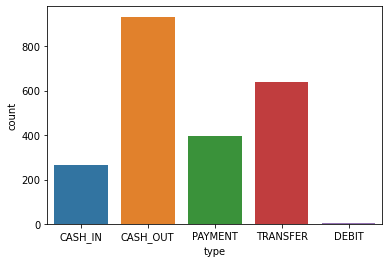

In [64]:
sns.countplot(x='type', data=data)


C:\Users\Ankitha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='step', ylabel='Density'>

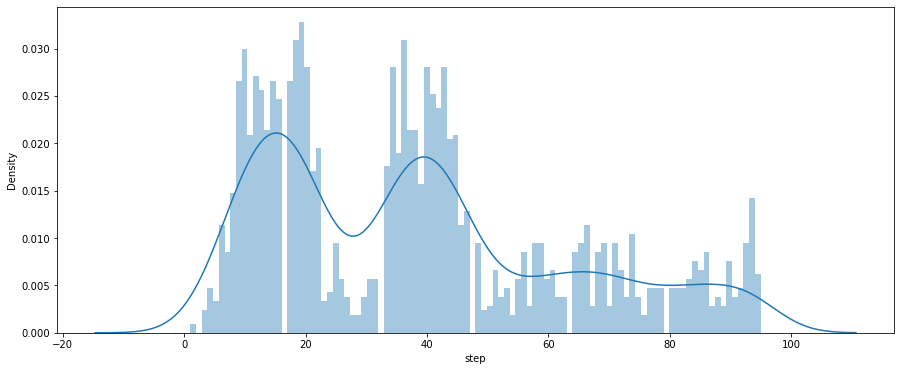

In [65]:
plt.figure(figsize=(15, 6))
sns.distplot(data['step'], bins=100)


<AxesSubplot:>

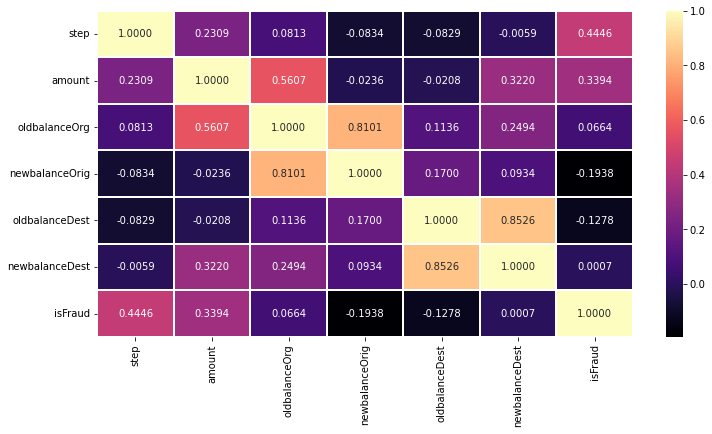

In [66]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(),
			cmap='magma',
			fmt='.4f',
			linewidths=2,
			annot=True)


In [67]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,22,CASH_IN,41158.47,C179057030,5987329.93,6028488.40,C1926445494,400543.10,359384.63,0,0,0,0,0
1,14,CASH_OUT,72452.61,C1219710868,0.00,0.00,C1465478513,1734469.92,1777347.58,0,1,0,0,0
2,41,CASH_OUT,7148.71,C1847885332,20217.00,13068.29,C497780866,8243767.22,8250915.93,0,1,0,0,0
3,43,PAYMENT,14491.14,C1362163448,269.00,0.00,M905148106,0.00,0.00,0,0,0,1,0
4,48,PAYMENT,7705.95,C2916264,59682.00,51976.05,M1985830583,0.00,0.00,0,0,0,1,0


In [68]:
x = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']


In [69]:
x.shape, y.shape


((2239, 10), (2239,))

In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
	x, y, test_size=0.3, random_state=42)


In [85]:
models = [LogisticRegression(), XGBClassifier(),
          SVC(kernel='rbf', probability=True),
          RandomForestClassifier(n_estimators=7,
                                 criterion='entropy', 
                                 random_state=7)]

In [86]:
    for i in range(len(models)):
        models[i].fit(x_train, y_train)
        print(f'{models[i]} : ')

        train_preds = models[i].predict_proba(x_train)[:, 1]
        print('Training Accuracy : ', ras(y_train, train_preds))

        y_preds = models[i].predict_proba(x_test)[:, 1]
        print('Validation Accuracy : ', ras(y_test, y_preds))
        print()

LogisticRegression() : 
Training Accuracy :  0.9744386873920553
Validation Accuracy :  0.9776191531811128

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9968787408556861

SVC(probability=True) : 
Training Accuracy :  0.9051357252256655

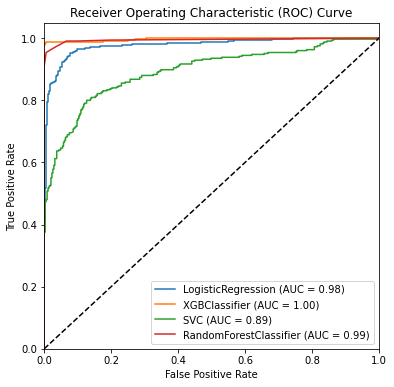

In [92]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curves for models(comparing all in one)
plt.figure(figsize=(6, 6))
for model in models:
    y_preds = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


C:\Users\Ankitha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


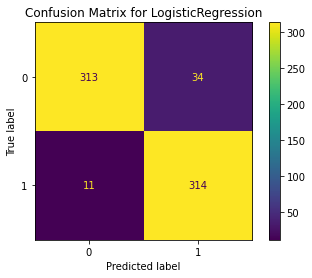

C:\Users\Ankitha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


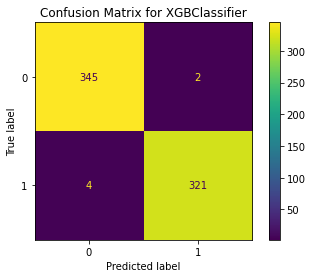

C:\Users\Ankitha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


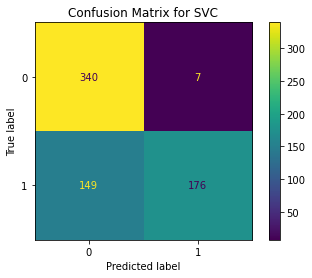

C:\Users\Ankitha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


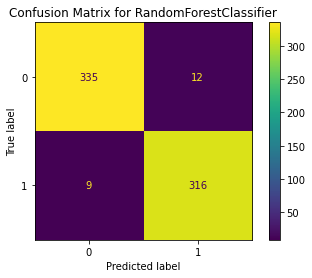

In [94]:
#confusion matrix modelwise
for model in models:
    plot_confusion_matrix(model, x_test, y_test)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()


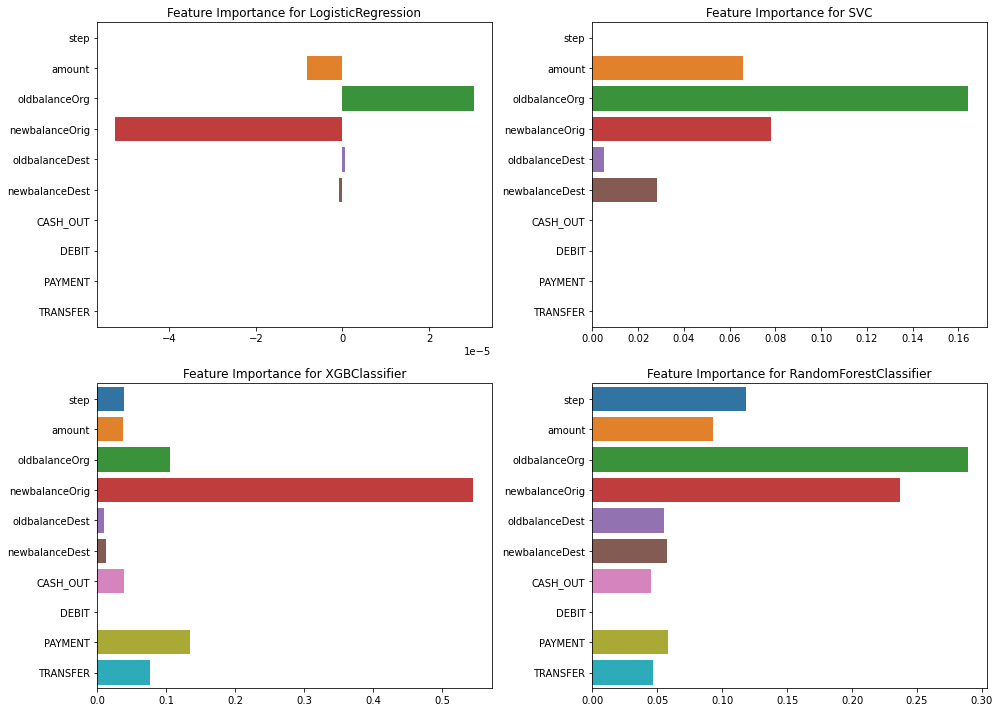

In [104]:

from sklearn.inspection import permutation_importance


for model in models:
    model.fit(x_train, y_train)

# Collect feature importances
feature_importances = {}

# Logistic Regression and SVM (coefficients)
for model in [models[0], models[2]]:  # LogisticRegression and SVC
    model_name = model.__class__.__name__
    if hasattr(model, 'coef_'):
        importances = model.coef_[0]
    else:
        result = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)
        importances = result.importances_mean
    feature_importances[model_name] = importances

# XGBoost and RandomForest (feature importances)
for model in [models[1], models[3]]:  # XGBClassifier and RandomForestClassifier
    model_name = model.__class__.__name__
    importances = model.feature_importances_
    feature_importances[model_name] = importances


plt.figure(figsize=(14, 10))
n_features = x.shape[1]
feature_names = x.columns

for i, (model_name, importances) in enumerate(feature_importances.items()):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=importances, y=feature_names)
    plt.title(f'Feature Importance for {model_name}')

plt.tight_layout()
plt.show()


In [103]:
from sklearn.neural_network import MLPClassifier


mlp_model = MLPClassifier(random_state=50)


mlp_model.fit(x_train, y_train)


train_preds_mlp = mlp_model.predict_proba(x_train)[:, 1]
test_preds_mlp = mlp_model.predict_proba(x_test)[:, 1]


print('Multi-layer Perceptron Classifier:')
print('Training AUC:', ras(y_train, train_preds_mlp))
print('Validation AUC:', ras(y_test, test_preds_mlp))


Multi-layer Perceptron Classifier:
Training AUC: 0.9188174145403591
Validation AUC: 0.9146708046996231


C:\Users\Ankitha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

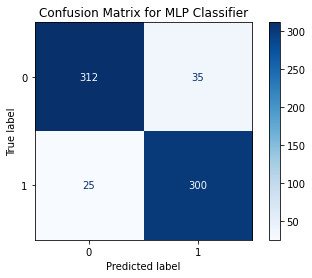

In [102]:

plt.figure(figsize=(8, 6))
plot_confusion_matrix(mlp_model, x_test, y_test, cmap=plt.cm.Blues, normalize=None)
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

